# CNN Network 

# Environment Init

In [118]:
import torch
import torch.nn.functional as F
import os
# import cv2 as cv
import numpy as np
from typing import Tuple
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
   
curPath=os.path.abspath('')
trainPath=curPath+"/../train"
print(trainPath)
print(torch.__version__)
print(torchvision.__version__)


/Users/jiaruiye/Desktop/FDU/专业课程/必修课程/人工智能/Projects/PJ1/Part2/../train
1.13.1
0.13.1a0


# Create Train Set & Test Set

In [119]:
BATCH_SIZE=512 
EPOCHS=20
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
DEVICE = torch.device("mps") 
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8874], std=[0.3159]),
    transforms.Grayscale(num_output_channels=1)
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root=trainPath, transform=transform)

# loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
# data = next(iter(loader))
# mean, std = data[0].mean(), data[0].std()

# print("Mean:", mean)
# print("Std:", std)

trainSet,testSet=torch.utils.data.random_split(dataset,[int(len(dataset)*0.9),len(dataset)-int(len(dataset)*0.9)])
print(len(trainSet))
print(len(testSet))
trainLoader=DataLoader(
    trainSet,
    batch_size=BATCH_SIZE,
    shuffle=True
 )
testLoader=DataLoader(
    testSet,
    batch_size=BATCH_SIZE,
    shuffle=True
)

6696
744


# Net Structure

In [120]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5) 
        self.conv2 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3) 
        self.dropout = torch.nn.Dropout(p=0.5)
        self.ln1 = torch.nn.Linear(in_features=24*10*10, out_features=512)
        self.ln2 = torch.nn.Linear(in_features=512, out_features=12) 
    def forward(self,x):
        # Size without cropping
        in_size = x.size(0) # batch_size=512
        out = self.conv1(x) # 1*28*28 -> 12*24*24 kernel_size=5
        out = F.relu(out) # 12*24*24
        out = F.max_pool2d(out, 2, 2) # 12*24*24 -> 12*12*12 pooling
        out = self.conv2(out) # 12*12*12 -> 24*10*10 kernel_size=3
        out = F.relu(out) # 24*10*10
        out = out.view(in_size, -1) # 24*10*10 -> 2400 Flatten
        out = self.ln1(out) # 2400 -> 512
        out = F.relu(out) # 512
        # out = self.dropout(out)
        out = self.ln2(out) # 512 -> 12
        out = F.log_softmax(out, dim=1)
        return out

# Optimizer

In [121]:
model = ConvNet().to(DEVICE)
# Define the optimizer

optimizer = torch.optim.Adam(model.parameters())

# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
print(model)

ConvNet(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (ln1): Linear(in_features=2400, out_features=512, bias=True)
  (ln2): Linear(in_features=512, out_features=12, bias=True)
)


# Train and Test

In [122]:
lossArray=[]
accuracyArray=[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%5 == 0 or batch_idx==13: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # 不自动求导
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item() # sum up the correct number

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    lossArray.append(test_loss)
    accuracyArray.append(100. * correct / len(test_loader.dataset))

# Load Model

In [116]:
# load the saved model
model.load_state_dict(torch.load('cnnCharacterClassificaion.pt'))

<All keys matched successfully>

# Main

In [123]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, trainLoader, optimizer, epoch)
    test(model, DEVICE, testLoader)

Train Epoch: 1 [2048/6696 (29%)]	Loss: 1.874105
Train Epoch: 1 [4608/6696 (64%)]	Loss: 0.989093
Train Epoch: 1 [520/6696 (93%)]	Loss: 0.565997

Test set: Average loss: 0.6855, Accuracy: 593/744 (80%)

Train Epoch: 2 [2048/6696 (29%)]	Loss: 0.571090
Train Epoch: 2 [4608/6696 (64%)]	Loss: 0.534826
Train Epoch: 2 [520/6696 (93%)]	Loss: 0.303656

Test set: Average loss: 0.4563, Accuracy: 651/744 (88%)

Train Epoch: 3 [2048/6696 (29%)]	Loss: 0.355667
Train Epoch: 3 [4608/6696 (64%)]	Loss: 0.311620
Train Epoch: 3 [520/6696 (93%)]	Loss: 0.244401

Test set: Average loss: 0.3300, Accuracy: 680/744 (91%)

Train Epoch: 4 [2048/6696 (29%)]	Loss: 0.241768
Train Epoch: 4 [4608/6696 (64%)]	Loss: 0.261725
Train Epoch: 4 [520/6696 (93%)]	Loss: 0.341987

Test set: Average loss: 0.2476, Accuracy: 695/744 (93%)

Train Epoch: 5 [2048/6696 (29%)]	Loss: 0.163207
Train Epoch: 5 [4608/6696 (64%)]	Loss: 0.207238
Train Epoch: 5 [520/6696 (93%)]	Loss: 0.146260

Test set: Average loss: 0.1857, Accuracy: 706/744 (9

# Dump Model

In [ ]:
# save the model
torch.save(model.state_dict(), 'cnnCharacterClassificaion.pt')

# Figure

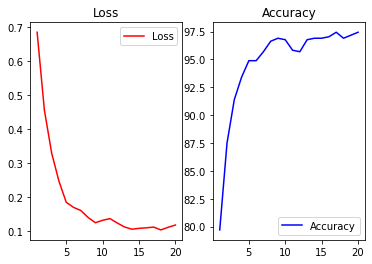

In [124]:
stepArray=[i+1 for i in range(EPOCHS)]
fig = plt.figure()
# plt.plot(stepArray,lossArray)
ax1 = fig.add_subplot(121)
l1=ax1.plot(stepArray, lossArray, color='red', label='Loss')
plt.title('Loss')
plt.legend()

ax2=fig.add_subplot(122)
l2=ax2.plot(stepArray,accuracyArray,color='blue',label='Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()